### GASS UVW

Notebook to test the uv coverage computation for an observation with a radio interferometer.

In [21]:
using Distances , Random 
using PyCall
using DataFrames
using LinearAlgebra
using LsqFit

import CSV 

rootdir = "/home/stephane/alma/ArrayConfig/GASS"

push!(LOAD_PATH,"$rootdir/master/src")
using GASS

import PyPlot

@pyimport astropy.coordinates as coord
@pyimport astropy.modeling.models as am
@pyimport astropy.modeling.fitting as mf

@pyimport numpy as np


## directory
datadir = "$rootdir/master/data"
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

### UVW methods

Several to manipulate and analyze uv-coverage in (radio) interferometry. The examples are taken from ALMA, a (sub-) millieter radio interferometer located in the desert of Atacama, Chile

In [22]:
## baseline coordinates
## arr: DataFrames with at least :X, :Y, :Z
## check at https://web.njit.edu/~gary/728/Lecture6.html

function calc_baselines(arr::AbstractDataFrame , lat=-23.0262015)
    
    coordinates= vcat(hcat(convert(Vector{Float64},arr[:X]))' ,
        hcat(convert(Vector{Float64},arr[:Y]))' ,
        hcat(convert(Vector{Float64},arr[:Z]))')
    rot= [0 -sind(lat) cosd(lat) ; 1 0 0 ; 0  cosd(lat)  sind(lat)]
    xyz= *(rot,coordinates)
    
    Nc= size(xyz)
    Nbl= convert(Int64,(Nc[2]*(Nc[2]-1))/2)   
    bl= zeros(Float64,3,2Nbl)   ## symmetry of the bl
    
    ibl= 1
    for i in 1:Nc[2]
        for j in i+1:Nc[2]
            bl[1,ibl]= xyz[1,i]-xyz[1,j] ; bl[1,ibl+Nbl]= xyz[1,j]-xyz[1,i]
            bl[2,ibl]= xyz[2,i]-xyz[2,j] ; bl[2,ibl+Nbl]= xyz[2,j]-xyz[2,i]
            bl[3,ibl]= xyz[3,i]-xyz[3,j] ; bl[3,ibl+Nbl]= xyz[3,j]-xyz[3,i]
            ibl += 1
        end
    end
    return(bl)
end

####
##  bl: baselines computed in calc_baselines
### h0: hour angle in degrees
### d0: source declination in degrees
function calc_uv(bl, h0, d0)
    
    proj= [sind(h0) cosd(h0) 0 ; -sind(d0)cosd(h0) sind(d0)sind(h0) cosd(d0) ; cosd(d0)cosd(h0) -cosd(d0)sind(h0) sind(d0)]
    uv= *(proj, bl)
    return(uv)
end

function calc_uv_coverage
    ## will compute the uv_coverage with an observing and sampling time ..
    ## for now only a snapshot.
end

calc_uv_coverage (generic function with 0 methods)

In [23]:
## Compute properties of a given UV coverage.
## a first shot is by using numpy
function mgrid(xsize, ysize)
    xx= []
    for i in 0:xsize
        push!(xx,fill!(zeros(Int64,xsize+1),i))
    end
    
    yy= []
    for j in 0:ysize
        push!(yy,collect(0:ysize))
    end
    
    println(size(xx))
    println(size(yy))
    return(xx,yy)
end

function pyuv_beamproperties(uv; npix=512, sizefit=60)
    lmax= maximum(abs.(uv))
    dx= 2lmax  / npix
    binx= range(-lmax,stop=lmax,length=npix)
    ds = dx / (299792458.0 / (100 * 1e9))
    dr= 180*3600/(π*npix*ds)   ## arcsec
    gaussian_sigma_to_fwhm=2.3548200450309493

    H, xd, yd = np.histogram2d(uv[1,:], uv[2,:], bins=(collect(binx), collect(binx)))
    
    ## appl ying Briggs weighting with a Robust parameter of 0.5
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H.>0].^2)/Hsum
    f2= (5*10^0.5)^2 * H2sum
    H2 = H ./ (1 .+ f2 .* H)
    
    h = np.fft[:fft2](H2)
    hshift = abs.(real.(np.fft[:fftshift](h)))
    
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    
    x, y = mgrid(sizefit, sizefit)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    p_init = am.Gaussian2D(amplitude=maximum(hshiftcut),x_mean=sizefit/2, y_mean=sizefit/2,
        x_stddev=1, y_stddev=1)
    
    fit_p = mf.LevMarLSQFitter()
    p = fit_p(p_init, x, y, hshiftcut, maxiter=100)
    println(p)
    println(p[:x_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:y_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:theta]*180/π)
    
    return(hshiftcut)
        
end

pyuv_beamproperties (generic function with 1 method)

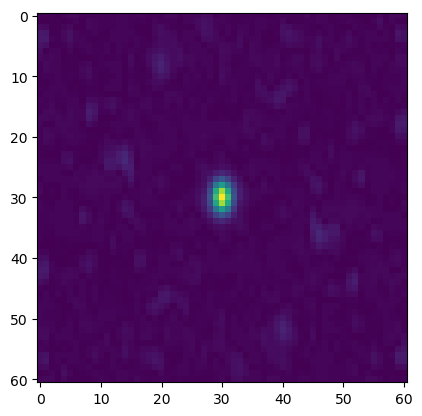

(61,)
(61,)
PyObject <Gaussian2D(amplitude=9.64464728, x_mean=30., y_mean=30., x_stddev=1.90554227, y_stddev=1.26672272, theta=0.00537504)>
PyObject 1.6670128519805913
PyObject 1.10815859801051
PyObject 0.3079670785587016


In [24]:
### Main
macro main(inpfile)
    cfg = read_cfg(inpfile)
    
    ## array test
    bl= calc_baselines(cfg.arr)
    uv= calc_uv(bl, 0, 30)
    dirty= pyuv_beamproperties(uv , npix=512)
   
    PyPlot.imshow(dirty)
    
    # PyPlot.plot(uv[1,:],uv[2,:], "b.")
    PyPlot.show()
    
end

@main("../master/data/GA_Inputs_O-10.txt.julia")